# فاز ۲ پروژه

حامد سعادتی 401212884، بهنام ساعدی 401202942

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sns.set_theme(style='whitegrid')

## آماده‌سازی و پیش‌پردازش داده‌ها

### خواندن دیتاست

In [2]:
# doenload datset if needed
!gdown "13XlJ4uhxxGprn6mnXwXNvV9PxSNyZCsY"
!mkdir -p datasets
!mv ./VideoCommentsThreatCorpus.txt ./datasets/

Downloading...
From: https://drive.google.com/uc?id=13XlJ4uhxxGprn6mnXwXNvV9PxSNyZCsY
To: /content/VideoCommentsThreatCorpus.txt
100% 2.87M/2.87M [00:00<00:00, 181MB/s]


In [3]:
def read_dataset(path):
    def read_lines(lines):
        is_header = True
        for line in lines:
            if is_header:
                is_header = False
                continue

            if not line or line.isspace():
                is_header = True
                continue

            label, comment = line.split(maxsplit=1)
            yield comment, int(label)

    with open(path, 'r') as file:
        data = read_lines(file)
        df = pd.DataFrame.from_records(data, columns=['text', 'label'])

    return df

df = read_dataset('datasets/VideoCommentsThreatCorpus.txt')
df

,text,label
0,It's because Europeans do not want to change t...,0
1,The Muslims there do not want to assimilate pr...,0
2,But it's ok....because Europe will soon rebel ...,1
3,I forsee a big civil war in Europe in the futu...,0
4,"ISLAM – A Simple, Humanitarian and Attractive ...",0
...,...,...
28638,yeah we are all monsters..I'm gonna kill u rig...,1
28639,stupid brainwashed idiot..\n,0
28640,have you EVER been to Serbia or kosovo...fucki...,0
28641,"probably u mean to this monsters, fucker /watc...",0


### حذف رکوردهای تکراری

In [4]:
df.drop_duplicates(inplace=True, ignore_index=True)
df

,text,label
0,It's because Europeans do not want to change t...,0
1,The Muslims there do not want to assimilate pr...,0
2,But it's ok....because Europe will soon rebel ...,1
3,I forsee a big civil war in Europe in the futu...,0
4,"ISLAM – A Simple, Humanitarian and Attractive ...",0
...,...,...
28286,yeah we are all monsters..I'm gonna kill u rig...,1
28287,stupid brainwashed idiot..\n,0
28288,have you EVER been to Serbia or kosovo...fucki...,0
28289,"probably u mean to this monsters, fucker /watc...",0


### نمایش توزیع برچسب‌ها

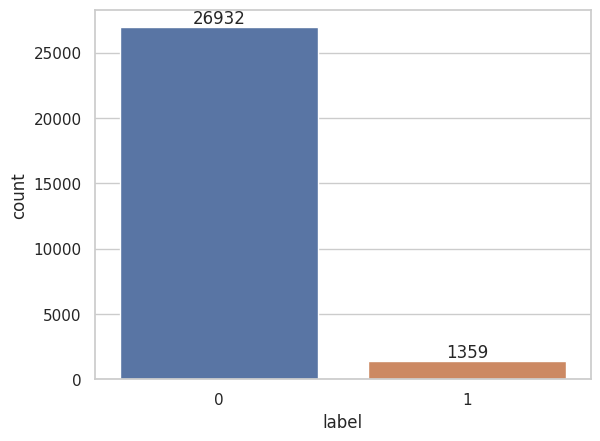

In [5]:
ax = sns.countplot(x=df['label'])
ax.bar_label(ax.containers[0])
plt.show()

<div dir="rtl">
می‌بینیم که برچسب‌ها بسیار نامتوازن هستند.
</div>

### جداسازی داده آموزشی و تست

In [6]:
test_size = 0.1

X_raw, y = df['text'], df['label']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw.values, y.values, test_size=test_size, stratify=y, random_state=0)
X_train_raw, X_test_raw = X_train_raw.flatten(), X_test_raw.flatten()

In [7]:
pd.DataFrame({
    'label 0 count': [(1 - y_train).sum(), (1 - y_test).sum()],
    'label 1 count': [y_train.sum(), y_test.sum()],
    'label 0 ratio': [(1 - y_train).mean(), (1 - y_test).mean()],
    'label 1 ratio': [y_train.mean(), y_test.mean()],
}, index=['train', 'test'])

,label 0 count,label 1 count,label 0 ratio,label 1 ratio
train,24238,1223,0.951966,0.048034
test,2694,136,0.951943,0.048057


In [8]:
# Helper function for reporting and submitting results
clf_macro_f1_scores = dict()
clf_bal_acc_scores = dict()

def report_classifier(clf, name: str, X_train, X_test, batch_size=1024):
    if hasattr(clf, 'predict'):
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
    else:
        def predict_batch(X, i):
            return clf(input_ids=X.input_ids[i:i+batch_size].cuda(),
                       token_type_ids=X.token_type_ids[i:i+batch_size].cuda(),
                       attention_mask=X.attention_mask[i:i+batch_size].cuda()
                       )[0].argmax(axis=1).cpu()

        with torch.no_grad():
            y_pred_train = torch.cat([predict_batch(X_train, i) for i in range(0, len(X_train.input_ids), batch_size)])
            y_pred_test = torch.cat([predict_batch(X_test, i) for i in range(0, len(X_test.input_ids), batch_size)])

    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')

    acc_train = balanced_accuracy_score(y_train, y_pred_train)
    acc_test = balanced_accuracy_score(y_test, y_pred_test)

    print(f'Train F1 score: {f1_train:0.3f}')
    print(f'Test F1 score: {f1_test:0.3f}')
    print(f'Train balanced accuracy: {acc_train * 100:0.1f}%')
    print(f'Test balanced accuracy: {acc_test * 100:0.1f}%')
    print()

    clf_macro_f1_scores[name] = f1_test
    clf_bal_acc_scores[name] = acc_test

    print(classification_report(y_test, y_pred_test, zero_division=1))

### ‫تبدیل متن به توکن با استفاده از nltk

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
vectorizer = CountVectorizer(
    strip_accents='unicode',
    stop_words=stopwords.words('english'),
    ngram_range=(1, 2),
    min_df=0.0005,
    max_df=0.8)

num_features_basic = vectorizer.fit_transform(X_train_raw).shape[1]
print('Number of features without preprocesing and feature selection', num_features_basic)

Number of features without preprocesing and feature selection 2444


In [11]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stopwords = set(stopwords.words('english'))

    def __call__(self, doc):
        nltk_tagged = pos_tag(word_tokenize(doc))
        wordnet_tagged = ((x[0], self.nltk_pos_tagger(x[1])) for x in nltk_tagged)

        return [self.wnl.lemmatize(token, tag)
                for token, tag in wordnet_tagged
                if token not in self.stopwords
                    and any(c.isalpha() for c in token)]

    def nltk_pos_tagger(self, nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

In [13]:
print(X_train_raw[0])
print('label is', bool(y_train[0]))

The solutiin is simple.....free Breivik and give him a permit to shoot islamists and leftists on sight

label is True


In [14]:
# test the correctness of the LemmaTokenizer
' '.join(LemmaTokenizer()(X_train_raw[0].lower()))

'solutiin simple free breivik give permit shoot islamist leftist sight'

## مدل‌سازی با استفاده از ویژگی تعداد کلمات

### پیش‌پردازش شمارش توکن‌ها

In [15]:
vectorizer = CountVectorizer(
    tokenizer=LemmaTokenizer(),
    strip_accents='unicode',
    ngram_range=(1, 2),
    min_df=0.0005,
    max_df=0.8)

X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)
X_train

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<25461x2304 sparse matrix of type '<class 'numpy.int64'>'
	with 155667 stored elements in Compressed Sparse Row format>

In [16]:
vectorizer.inverse_transform(X_train[0])

[array(['simple', 'free', 'breivik', 'give', 'shoot', 'islamist',
        'leftist'], dtype='<U20')]

### ‫به‌دست آوردن دقت مدل baseline

In [17]:
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [18]:
report_classifier(clf, 'DummyClassifier (most frequent)', X_train, X_test)

Train F1 score: 0.488
Test F1 score: 0.488
Train balanced accuracy: 50.0%
Test balanced accuracy: 50.0%

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2694
           1       1.00      0.00      0.00       136

    accuracy                           0.95      2830
   macro avg       0.98      0.50      0.49      2830
weighted avg       0.95      0.95      0.93      2830



In [19]:
clf = DummyClassifier(strategy='uniform')
clf.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [20]:
report_classifier(clf, 'DummyClassifier (uniform)', X_train, X_test)

Train F1 score: 0.373
Test F1 score: 0.375
Train balanced accuracy: 50.8%
Test balanced accuracy: 49.4%

              precision    recall  f1-score   support

           0       0.95      0.51      0.66      2694
           1       0.05      0.48      0.09       136

    accuracy                           0.51      2830
   macro avg       0.50      0.49      0.37      2830
weighted avg       0.91      0.51      0.64      2830



### ‫مدل‌های Naive Bayes

In [21]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [22]:
report_classifier(clf, 'MultinomialNB (count vectorization)', X_train, X_test)

Train F1 score: 0.783
Test F1 score: 0.724
Train balanced accuracy: 77.3%
Test balanced accuracy: 70.4%

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2694
           1       0.53      0.43      0.47       136

    accuracy                           0.95      2830
   macro avg       0.75      0.70      0.72      2830
weighted avg       0.95      0.95      0.95      2830



In [23]:
clf = ComplementNB()
clf.fit(X_train, y_train)

ComplementNB()

In [24]:
report_classifier(clf, 'ComplementNB (count vectorization)', X_train, X_test)

Train F1 score: 0.623
Test F1 score: 0.606
Train balanced accuracy: 87.2%
Test balanced accuracy: 82.7%

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      2694
           1       0.19      0.83      0.31       136

    accuracy                           0.82      2830
   macro avg       0.59      0.83      0.61      2830
weighted avg       0.95      0.82      0.87      2830



### ‫کاهش تعداد ویژگی با استفاده از SVD

In [25]:
truncated_svd = TruncatedSVD(n_components=200, random_state=0)
X_train_reduced = truncated_svd.fit_transform(X_train)
X_test_reduced = truncated_svd.transform(X_test)
X_train_reduced.shape, X_test_reduced.shape

((25461, 200), (2830, 200))

In [26]:
truncated_svd.explained_variance_ratio_.sum()

0.5505850512482723

### استانداردسازی ویژگی‌ها

In [27]:
scaler = StandardScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.transform(X_test_reduced)

### ‫دسته‌بند Ridge

In [28]:
parameters = {'alpha': (0, 0.1, 0.3, 1, 3, 10)}
grid_search = GridSearchCV(RidgeClassifier(class_weight='balanced',
                                           random_state=0),
                           param_grid=parameters,
                           scoring='f1_macro',
                           cv=3,
                           n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

clf = grid_search.best_estimator_
clf

RidgeClassifier(alpha=10, class_weight='balanced', random_state=0)

In [29]:
report_classifier(clf, 'RidgeClassifier (count vectorization)', X_train_reduced, X_test_reduced)

Train F1 score: 0.614
Test F1 score: 0.611
Train balanced accuracy: 78.2%
Test balanced accuracy: 75.1%

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2694
           1       0.20      0.63      0.30       136

    accuracy                           0.86      2830
   macro avg       0.59      0.75      0.61      2830
weighted avg       0.94      0.86      0.89      2830



### ‫دسته‌بند SVM

In [30]:
parameters = {
    'C': (1, 3, 10, 30, 100),
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid')
}
grid_search = RandomizedSearchCV(SVC(class_weight='balanced',
                                     random_state=0,
                                     max_iter=1000),
                                 param_distributions=parameters,
                                 scoring='f1_macro',
                                 cv=3,
                                 n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

clf = grid_search.best_estimator_
clf

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=30, class_weight='balanced', kernel='sigmoid', max_iter=1000,
    random_state=0)

In [31]:
report_classifier(clf, 'SVC (count vectorization)', X_train_reduced, X_test_reduced)

Train F1 score: 0.417
Test F1 score: 0.431
Train balanced accuracy: 62.1%
Test balanced accuracy: 65.5%

              precision    recall  f1-score   support

           0       0.98      0.57      0.72      2694
           1       0.08      0.74      0.14       136

    accuracy                           0.57      2830
   macro avg       0.53      0.65      0.43      2830
weighted avg       0.93      0.57      0.69      2830



### ‫دسته‌بند Random Forest

In [33]:
parameters = {
    'criterion': ('gini', 'entropy'),
    'max_depth': range(4, 13, 4),
}
grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', 
                                                  random_state=0),
                           param_grid=parameters,
                           scoring='f1_macro',
                           cv=3,
                           n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

clf = grid_search.best_estimator_
clf

RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=0)

In [34]:
report_classifier(clf, 'RandomForestClassifier (count vectorization)', X_train_reduced, X_test_reduced)

Train F1 score: 0.848
Test F1 score: 0.698
Train balanced accuracy: 89.0%
Test balanced accuracy: 69.6%

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2694
           1       0.43      0.42      0.43       136

    accuracy                           0.95      2830
   macro avg       0.70      0.70      0.70      2830
weighted avg       0.94      0.95      0.95      2830



### ‫دسته‌بند MLP

In [35]:
parameters = {
    'hidden_layer_sizes': [(100, ), (200, ), (400, ), (100, 100), (200, 100)],
}
grid_search = GridSearchCV(MLPClassifier(activation='relu',
                                         random_state=0),
                           param_grid=parameters,
                           scoring='f1_macro',
                           cv=3,
                           n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

clf = grid_search.best_estimator_
clf

MLPClassifier(hidden_layer_sizes=(400,), random_state=0)

In [36]:
report_classifier(clf, 'MLPClassifier (count vectorization)', X_train_reduced, X_test_reduced)

Train F1 score: 0.978
Test F1 score: 0.662
Train balanced accuracy: 96.4%
Test balanced accuracy: 62.9%

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2694
           1       0.49      0.27      0.35       136

    accuracy                           0.95      2830
   macro avg       0.73      0.63      0.66      2830
weighted avg       0.94      0.95      0.94      2830



## ‫مدل‌سازی با استفاده از ویژگی‌های TF-IDF

In [37]:
vectorizer = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),
    strip_accents='unicode',
    ngram_range=(1, 2),
    min_df=0.0005,
    max_df=0.8)

X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)
X_train

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<25461x2304 sparse matrix of type '<class 'numpy.float64'>'
	with 155667 stored elements in Compressed Sparse Row format>

### ‫مدل‌های Naive Bayes

In [38]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [39]:
report_classifier(clf, 'MultinomialNB (TF-IDF vectorization)', X_train, X_test)

Train F1 score: 0.582
Test F1 score: 0.550
Train balanced accuracy: 55.1%
Test balanced accuracy: 53.3%

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2694
           1       0.82      0.07      0.12       136

    accuracy                           0.95      2830
   macro avg       0.89      0.53      0.55      2830
weighted avg       0.95      0.95      0.94      2830



In [40]:
clf = ComplementNB()
clf.fit(X_train, y_train)

ComplementNB()

In [41]:
report_classifier(clf, 'ComplementNB (TF-IDF vectorization)', X_train, X_test)

Train F1 score: 0.621
Test F1 score: 0.610
Train balanced accuracy: 85.8%
Test balanced accuracy: 82.7%

              precision    recall  f1-score   support

           0       0.99      0.83      0.90      2694
           1       0.20      0.82      0.32       136

    accuracy                           0.83      2830
   macro avg       0.59      0.83      0.61      2830
weighted avg       0.95      0.83      0.87      2830



### ‫کاهش تعداد ویژگی با استفاده از SVD

In [42]:
truncated_svd = TruncatedSVD(n_components=200, random_state=0)
X_train_reduced = truncated_svd.fit_transform(X_train)
X_test_reduced = truncated_svd.transform(X_test)
X_train_reduced.shape, X_test_reduced.shape

((25461, 200), (2830, 200))

In [43]:
truncated_svd.explained_variance_ratio_.sum()

0.3952687689167944

### استانداردسازی ویژگی‌ها

In [44]:
scaler = StandardScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.transform(X_test_reduced)

### ‫دسته‌بند Ridge

In [45]:
parameters = {'alpha': (0, 0.1, 0.3, 1, 3, 10)}
grid_search = GridSearchCV(RidgeClassifier(class_weight='balanced',
                                           random_state=0),
                           param_grid=parameters,
                           scoring='f1_macro',
                           cv=3,
                           n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

clf = grid_search.best_estimator_
clf

RidgeClassifier(alpha=3, class_weight='balanced', random_state=0)

In [46]:
report_classifier(clf, 'RidgeClassifier (TF-IDF vectorization)', X_train_reduced, X_test_reduced)

Train F1 score: 0.654
Test F1 score: 0.656
Train balanced accuracy: 83.3%
Test balanced accuracy: 82.2%

              precision    recall  f1-score   support

           0       0.99      0.89      0.93      2694
           1       0.25      0.76      0.38       136

    accuracy                           0.88      2830
   macro avg       0.62      0.82      0.66      2830
weighted avg       0.95      0.88      0.91      2830



### ‫دسته‌بند SVM

In [47]:
parameters = {
    'C': (1, 10, 30, 100),
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid')
}
grid_search = RandomizedSearchCV(SVC(class_weight='balanced',
                                     random_state=0,
                                     max_iter=1000),
                                 param_distributions=parameters,
                                 scoring='f1_macro',
                                 cv=3,
                                 n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

clf = grid_search.best_estimator_
clf

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=10, class_weight='balanced', max_iter=1000, random_state=0)

In [48]:
report_classifier(clf, 'SVC (TF-IDF vectorization)', X_train_reduced, X_test_reduced)

Train F1 score: 0.612
Test F1 score: 0.550
Train balanced accuracy: 75.5%
Test balanced accuracy: 62.9%

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2694
           1       0.13      0.40      0.19       136

    accuracy                           0.84      2830
   macro avg       0.55      0.63      0.55      2830
weighted avg       0.93      0.84      0.88      2830



### ‫دسته‌بند Random Forest

In [49]:
parameters = {
    'criterion': ('gini', 'entropy'),
    'max_depth': range(4, 13, 4),
}
grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', 
                                                  random_state=0),
                           param_grid=parameters,
                           scoring='f1_macro',
                           cv=3,
                           n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

clf = grid_search.best_estimator_
clf

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, random_state=0)

In [50]:
report_classifier(clf, 'RandomForestClassifier (TF-IDF vectorization)', X_train_reduced, X_test_reduced)

Train F1 score: 0.852
Test F1 score: 0.696
Train balanced accuracy: 88.2%
Test balanced accuracy: 69.8%

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2694
           1       0.42      0.43      0.42       136

    accuracy                           0.94      2830
   macro avg       0.69      0.70      0.70      2830
weighted avg       0.94      0.94      0.94      2830



### ‫دسته‌بند MLP

In [51]:
parameters = {
    'hidden_layer_sizes': [(100, ), (200, ), (400, ), (100, 100), (200, 100)],
}
grid_search = GridSearchCV(MLPClassifier(activation='relu',
                                         random_state=0),
                           param_grid=parameters,
                           scoring='f1_macro',
                           cv=3,
                           n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

clf = grid_search.best_estimator_
clf

MLPClassifier(hidden_layer_sizes=(200, 100), random_state=0)

In [52]:
report_classifier(clf, 'MLPClassifier (TF-IDF vectorization)', X_train_reduced, X_test_reduced)

Train F1 score: 0.988
Test F1 score: 0.726
Train balanced accuracy: 99.0%
Test balanced accuracy: 69.5%

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2694
           1       0.57      0.40      0.47       136

    accuracy                           0.96      2830
   macro avg       0.77      0.69      0.73      2830
weighted avg       0.95      0.96      0.95      2830



## ‫مدل مبتنی بر BERT transformer

In [53]:
# install necessary packages if needed
!pip install transformers[torch] -q
!pip install accelerate -U -q

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, EarlyStoppingCallback, IntervalStrategy, Trainer, TrainingArguments

In [55]:
# Define the tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Length covering 90% of text: 56


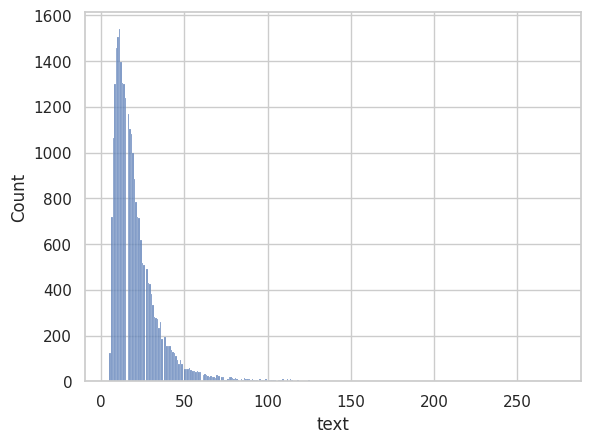

In [56]:
# Finding an optimum max token length for text truncation
X_tokenized = df['text'].apply(bert_tokenizer).apply(lambda tokenized: len(tokenized.input_ids))
sns.histplot(X_tokenized)
print('Length covering 90% of text:', X_tokenized.sort_values()[len(df) // 10])

In [57]:
# using the above graph we choose 64
truncation_length = 64

In [58]:
# Tokenize text
X_train = bert_tokenizer(X_train_raw.tolist(), max_length=truncation_length,
    padding="max_length", truncation=True, return_tensors='pt')

X_test = bert_tokenizer(X_test_raw.tolist(), max_length=truncation_length,
    padding="max_length", truncation=True, return_tensors='pt')

X_train

{'input_ids': tensor([[  101,  1996, 14017,  ...,     0,     0,     0],
        [  101,  2057,  2064,  ...,     0,     0,     0],
        [  101,  2000,  2070,  ...,     0,     0,     0],
        ...,
        [  101,  9413,  7842,  ...,  2094,   102,     0],
        [  101,  2017,  2323,  ...,     0,     0,     0],
        [  101,  2049,  2995,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [59]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X.input_ids)

    def __getitem__(self, index):
        return {
            'input_ids': self.X.input_ids[index],
            'token_type_ids': self.X.token_type_ids[index],
            'attention_mask': self.X.attention_mask[index],
            'labels': torch.LongTensor([self.y[index]]),
        }

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_test, y_test)

In [60]:
# Calculate class weights for training because of data imbalance
class_weights = [(y_train == 1).sum() / len(y_train), (y_train == 0).sum() / len(y_train)]
class_weights

[0.04803424845842661, 0.9519657515415734]

In [61]:
# release GPU memory if needed
import gc

if 'model' in globals():
    model.cpu()
    del model
if 'trainer' in globals():
    del trainer

gc.collect()
torch.cuda.empty_cache()

In [62]:
class Classifier(nn.Module):
    def __init__(self, embedding_tokenizer, embedding_model):
        super().__init__()
        self.embedding_size = 768

        self.embedding = embedding_model
        self.classifier = nn.Linear(self.embedding_size, 1)
        self.sigmoid = torch.sigmoid

    def forward(self, x):
        tokenized = self.tokenizer(x, max_length=128, padding="max_length", truncation=True, return_tensors='pt')
        outputs = self.embedding(input_ids=tokenized.input_ids.cuda(),
                                 token_type_ids=tokenized.token_type_ids.cuda(),
                                 attention_mask=tokenized.attention_mask.cuda())
        pooler_output = outputs.pooler_output
        y = self.classifier(pooler_output)
        return self.sigmoid(y)

    def predict(self, x):
        y = self.forward(x)
        return (y > 0.5).float()

In [63]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.FloatTensor(class_weights).cuda()

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels').view(-1)

        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')

        # compute custom loss
        loss = F.cross_entropy(logits, labels, weight=self.class_weights)

        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    logging_steps=100,
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    evaluation_strategy=IntervalStrategy.STEPS, 
    metric_for_best_model='f1',
    load_best_model_at_end=True,
)

def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    return {
        "balanced_accuracy": balanced_accuracy_score(y_true=labels, y_pred=pred),
        "f1": f1_score(y_true=labels, y_pred=pred, average='macro')
    }

trainer = CustomTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    class_weights=class_weights,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Step,Training Loss,Validation Loss,Balanced Accuracy,F1
100,0.666100,0.588990,0.690407,0.664156
200,0.497000,0.329926,0.856255,0.788199
300,0.320700,0.475878,0.844032,0.834679
400,0.332900,0.611362,0.846595,0.829325
500,0.481400,0.485688,0.863864,0.833516
600,0.459500,0.464587,0.817776,0.837790
700,0.375700,0.319648,0.881018,0.886413
800,0.355400,0.350093,0.861522,0.865348
900,0.208500,0.269916,0.928335,0.839926
1000,0.252700,0.547881,0.863193,0.879060


TrainOutput(global_step=2100, training_loss=0.2756029608136132, metrics={'train_runtime': 942.9045, 'train_samples_per_second': 81.008, 'train_steps_per_second': 2.533, 'total_flos': 2209409309621760.0, 'train_loss': 0.2756029608136132, 'epoch': 2.64})

In [64]:
trainer.evaluate()

{'eval_loss': 0.3517189919948578,
 'eval_balanced_accuracy': 0.8907485043014979,
 'eval_f1': 0.8827292680905443,
 'eval_runtime': 9.6438,
 'eval_samples_per_second': 293.453,
 'eval_steps_per_second': 4.666,
 'epoch': 2.64}

In [65]:
report_classifier(model, 'BERT classifier', X_train, X_test)

Train F1 score: 0.957
Test F1 score: 0.883
Train balanced accuracy: 97.9%
Test balanced accuracy: 89.1%

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2694
           1       0.76      0.79      0.78       136

    accuracy                           0.98      2830
   macro avg       0.88      0.89      0.88      2830
weighted avg       0.98      0.98      0.98      2830



## ارزیابی مدل

In [66]:
clf_bal_acc_scores

{'DummyClassifier (most frequent)': 0.5,
 'DummyClassifier (uniform)': 0.49379612646840476,
 'MultinomialNB (count vectorization)': 0.7035842176514259,
 'ComplementNB (count vectorization)': 0.8272823049041442,
 'RidgeClassifier (count vectorization)': 0.7514028996899428,
 'SVC (count vectorization)': 0.6545455041704877,
 'RandomForestClassifier (count vectorization)': 0.6956390017031312,
 'MLPClassifier (count vectorization)': 0.6287911044150399,
 'MultinomialNB (TF-IDF vectorization)': 0.5327170400454169,
 'ComplementNB (TF-IDF vectorization)': 0.8267609939298659,
 'RidgeClassifier (TF-IDF vectorization)': 0.8220691951613608,
 'SVC (TF-IDF vectorization)': 0.6287447050089523,
 'RandomForestClassifier (TF-IDF vectorization)': 0.6982018865452639,
 'MLPClassifier (TF-IDF vectorization)': 0.6945963797545744,
 'BERT classifier': 0.8907485043014979}

In [67]:
clf_macro_f1_scores

{'DummyClassifier (most frequent)': 0.4876900796524258,
 'DummyClassifier (uniform)': 0.3745097678069798,
 'MultinomialNB (count vectorization)': 0.7237664471214347,
 'ComplementNB (count vectorization)': 0.6056316430419871,
 'RidgeClassifier (count vectorization)': 0.6114107588944804,
 'SVC (count vectorization)': 0.43052301876377386,
 'RandomForestClassifier (count vectorization)': 0.6984061517339121,
 'MLPClassifier (count vectorization)': 0.6618631036489071,
 'MultinomialNB (TF-IDF vectorization)': 0.549524870713749,
 'ComplementNB (TF-IDF vectorization)': 0.6099926690996259,
 'RidgeClassifier (TF-IDF vectorization)': 0.6563046152784804,
 'SVC (TF-IDF vectorization)': 0.5504515115822537,
 'RandomForestClassifier (TF-IDF vectorization)': 0.6961458597113194,
 'MLPClassifier (TF-IDF vectorization)': 0.7258309404619725,
 'BERT classifier': 0.8827292680905443}

### مقایسه نتایج

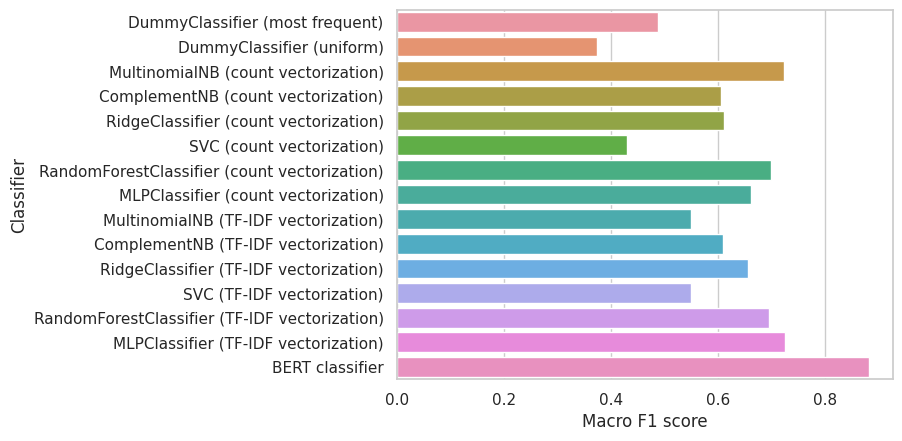

In [68]:
plt.figure(dpi=100)
df_macro_f1_score = pd.DataFrame({'Classifier': clf_macro_f1_scores.keys(), 'Macro F1 score': clf_macro_f1_scores.values()})
sns.barplot(data=df_macro_f1_score, x='Macro F1 score', y='Classifier')
plt.show()

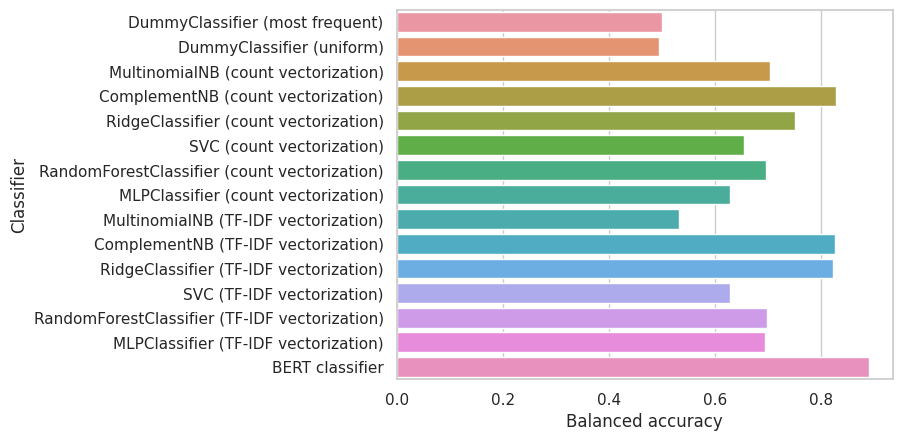

In [69]:
plt.figure(dpi=100)
df_bal_acc_score = pd.DataFrame({'Classifier': clf_bal_acc_scores.keys(), 'Balanced accuracy': clf_bal_acc_scores.values()})
sns.barplot(data=df_bal_acc_score, x='Balanced accuracy', y='Classifier')
plt.show()

### ارزیابی نمودار آموزش مدل انتخاب شده با متریک‌های موردنظر

In [78]:
history = [i for i in trainer.state.log_history if 'eval_f1' in i]

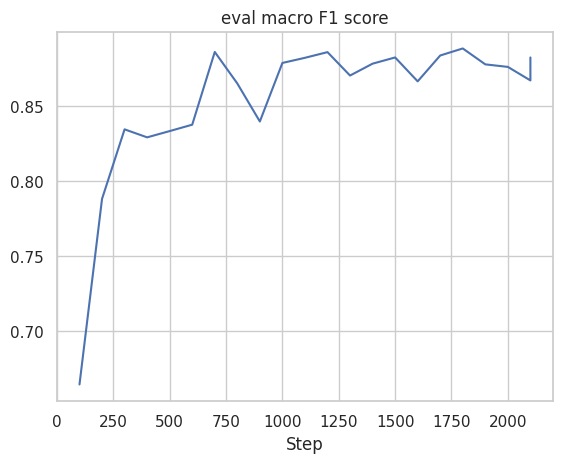

In [84]:
plt.plot([i['step'] for i in history], [i['eval_f1'] for i in history])
plt.title('eval macro F1 score')
plt.xlabel('Step')
plt.show()

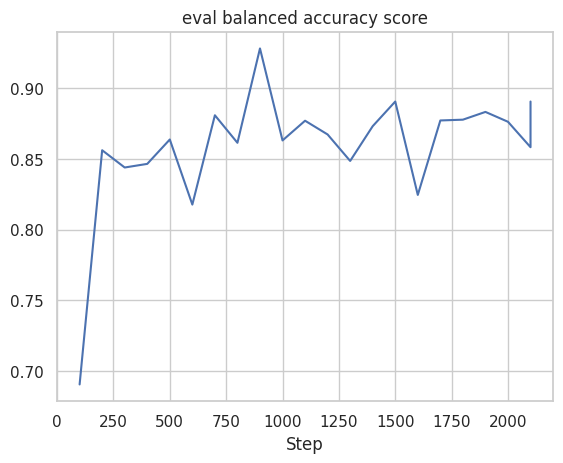

In [85]:
plt.plot([i['step'] for i in history], [i['eval_balanced_accuracy'] for i in history])
plt.title('eval balanced accuracy score')
plt.xlabel('Step')
plt.show()